In [1]:
import pandas as pd
import sys

# Data set preprocessing

## Load

In [2]:
# Import multiple latency values
p50 = pd.read_csv("Dataset/p50_latency_gcp.csv")
p95 = pd.read_csv("Dataset/p95_latency_gcp.csv")
p99 = pd.read_csv("Dataset/p99_latency_gcp.csv")
gcp_rps = pd.read_csv("Dataset/gcp_rps.csv")

#Concatenate multiple values
df = pd.concat([p50,p95,p99,gcp_rps], axis=1)

In [3]:
# Assign WEIGHTS
# Configure weights - The idea is to give a very low importance to those services that are not direclty connected
## Multiply *1 - Direct connection
## Multiply *0.3 - 2nd  connection ( Payment , email, redis and product catalog)
weight = 0.3

for col in df.columns:
        if 'redis' in col:
            df[col] = df[col].multiply(weight)
        if 'email' in col:
            df[col] = df[col].multiply(weight)
        if 'payment' in col:
            df[col] = df[col].multiply(weight)

#Send target to the end
s = df.pop('p95 deploy/frontend')
df = pd.concat([df, s], 1)

# Time is multiple times present. I need to keep just 1 sample for time since all of them will have the same value
df=df.loc[:, ~df.columns.duplicated(keep='first')]

#Convert time column to time format
df['Time'] = pd.to_datetime(df['Time'])
df.head()

/var/folders/hh/z9bqb5y14vs83vfz56nrhwtw0000gs/T/ipykernel_24716/1440968538.py:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([df, s], 1)


,Time,p50 deploy/adservice,p50 deploy/cartservice,p50 deploy/checkoutservice,p50 deploy/currencyservice,p50 deploy/emailservice,p50 deploy/frontend,p50 deploy/loadgenerator,p50 deploy/paymentservice,p50 deploy/productcatalogservice,...,deploy/currencyservice,deploy/emailservice,deploy/frontend,deploy/loadgenerator,deploy/paymentservice,deploy/productcatalogservice,deploy/recommendationservice,deploy/redis-cart,deploy/shippingservice,p95 deploy/frontend
0,2021-10-07 09:18:00,3.166667,1.257143,23.333333,0.552147,0.200,43.235294,0.75,0.1875,0.504373,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20002,131.000000
1,2021-10-07 09:18:05,2.500000,1.500000,10.000000,0.552147,0.225,43.235294,0.75,0.1875,0.506309,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20002,131.000000
2,2021-10-07 09:18:10,2.500000,1.500000,10.000000,0.551136,0.225,41.071429,0.75,0.3000,0.506309,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20000,99.027778
3,2021-10-07 09:18:15,2.194444,1.354839,25.000000,0.551136,0.270,41.071429,0.75,0.3000,0.502907,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20000,99.027778
4,2021-10-07 09:18:20,2.194444,1.354839,25.000000,0.541985,0.270,41.111111,0.75,0.2625,0.502907,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20000,240.000000


## Normalization

In [4]:
from sklearn.preprocessing import MinMaxScaler

## Split train and Test
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 3)

df.set_index('Time', inplace=True)
df.sort_index(inplace=True)
X = df.drop(labels=['p95 deploy/frontend'], axis=1)
y = df['p95 deploy/frontend']

In [5]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

<AxesSubplot: xlabel='Time'>

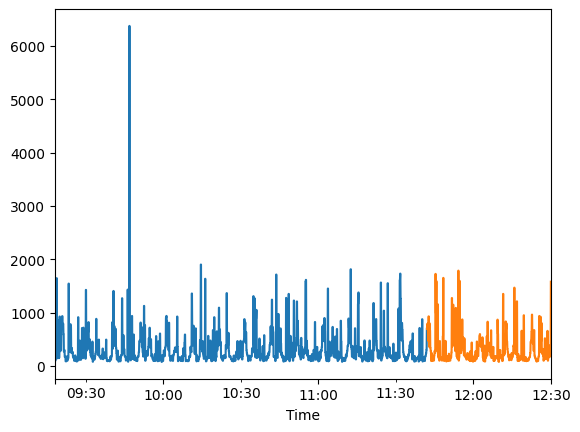

In [6]:
y_train.groupby('Time').mean().plot()
y_test.groupby('Time').mean().plot()

In [7]:
# Normalization between 0 and 1 JUST THE FEATURES
scaler_X = MinMaxScaler(feature_range=(0,1))
X_train = scaler_X.fit_transform(X_train)
X_test= scaler_X.transform(X_test)
X_test= scaler_X.transform(X_test)
X_test= scaler_X.transform(X_test)


/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## Save Train and Test datasets

In [8]:
#Save labels 
df_x_label = pd.DataFrame(y_train)
df_y_label = pd.DataFrame(y_test)

#Save trainX
df_x_train = pd.DataFrame(X_train)
df_x_test = pd.DataFrame(X_test)

In [9]:
# Replicate indexes to be able to concatenate
df_x_train.index = df_x_label.index
df_x_test.index = df_y_label.index

In [10]:
# Concatenate and save
train = pd.concat([df_x_train,df_x_label],axis=1)
train.index.name = "date"
train.to_csv('Dataset/Train/train_norm.csv')
test = pd.concat([df_x_test,df_y_label],axis=1)
test.to_csv('Dataset/Test/test_norm.csv')
train

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,p95 deploy/frontend
date,,,,,,,,,,,,,,,,,,,,,
2021-10-07 09:18:00,1.000000,0.157143,0.101040,0.044530,0.095238,0.070410,2.220446e-16,0.071429,0.033017,0.577778,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,1.00000,131.000000
2021-10-07 09:18:05,0.750000,0.400000,0.041605,0.044530,0.142857,0.070410,2.220446e-16,0.071429,0.047634,0.577778,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,1.00000,131.000000
2021-10-07 09:18:10,0.750000,0.400000,0.041605,0.043667,0.142857,0.063853,2.220446e-16,0.285714,0.047634,0.371429,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,0.49995,99.027778
2021-10-07 09:18:15,0.635417,0.254839,0.108470,0.043667,0.228571,0.063853,2.220446e-16,0.285714,0.021948,0.371429,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,0.49995,99.027778
2021-10-07 09:18:20,0.635417,0.254839,0.108470,0.035852,0.228571,0.063973,2.220446e-16,0.214286,0.021948,0.320000,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,0.49995,240.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-07 11:41:40,0.000000,0.331507,0.041605,0.060057,0.285714,0.169192,1.110223e-16,0.071429,0.043823,0.462763,...,0.49985,0.49995,0.49995,0.454000,0.0,0.388461,0.49995,0.0,0.49995,232.272727
2021-10-07 11:41:45,0.001913,0.400000,0.041605,0.060057,0.571429,0.169192,1.110223e-16,0.071429,0.216677,0.462763,...,0.49985,0.49995,0.49995,0.544909,0.0,0.610683,0.49995,0.0,0.49995,232.272727
2021-10-07 11:41:50,0.001913,0.400000,0.041605,0.091994,0.571429,0.193548,1.110223e-16,0.228571,0.216677,0.517647,...,0.49985,0.49995,0.49995,0.544909,0.0,0.610683,0.49995,0.0,0.49995,302.727273


# Models

## Informer

In [11]:
import sys
import os
sys.path.append('/Users/emlanza/Library/CloudStorage/OneDrive-UniversidadAustral/Facultad/Maestria Data Science AUSTRAL/Tesis/Transformers-for-latency-prediction/Informer/Informer2020')

In [12]:
from data.data_loader import Dataset_Custom
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
from torch.utils.data import DataLoader
import pandas as pd
import os

In [13]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'train_norm' # data
args.root_path = './Dataset/Train/' # root path of data file
args.data_path = 'train_norm.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'p95 deploy/frontend' # target feature in S or MS task
args.freq = '5s' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

#args.use_gpu = True if torch.cuda.is_available() else False
#args.gpu = 0

#args.use_multi_gpu = False
#args.devices = '0,1,2,3'

In [14]:
df1 = pd.read_csv(os.path.join(args.root_path, args.data_path))
df1

,date,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,p95 deploy/frontend
0,2021-10-07 09:18:00,1.000000,0.157143,0.101040,0.044530,0.095238,0.070410,2.220446e-16,0.071429,0.033017,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,1.00000,131.000000
1,2021-10-07 09:18:05,0.750000,0.400000,0.041605,0.044530,0.142857,0.070410,2.220446e-16,0.071429,0.047634,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,1.00000,131.000000
2,2021-10-07 09:18:10,0.750000,0.400000,0.041605,0.043667,0.142857,0.063853,2.220446e-16,0.285714,0.047634,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,0.49995,99.027778
3,2021-10-07 09:18:15,0.635417,0.254839,0.108470,0.043667,0.228571,0.063853,2.220446e-16,0.285714,0.021948,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,0.49995,99.027778
4,2021-10-07 09:18:20,0.635417,0.254839,0.108470,0.035852,0.228571,0.063973,2.220446e-16,0.214286,0.021948,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,0.49995,240.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,2021-10-07 11:41:40,0.000000,0.331507,0.041605,0.060057,0.285714,0.169192,1.110223e-16,0.071429,0.043823,...,0.49985,0.49995,0.49995,0.454000,0.0,0.388461,0.49995,0.0,0.49995,232.272727
1725,2021-10-07 11:41:45,0.001913,0.400000,0.041605,0.060057,0.571429,0.169192,1.110223e-16,0.071429,0.216677,...,0.49985,0.49995,0.49995,0.544909,0.0,0.610683,0.49995,0.0,0.49995,232.272727
1726,2021-10-07 11:41:50,0.001913,0.400000,0.041605,0.091994,0.571429,0.193548,1.110223e-16,0.228571,0.216677,...,0.49985,0.49995,0.49995,0.544909,0.0,0.610683,0.49995,0.0,0.49995,302.727273
1727,2021-10-07 11:41:55,0.001420,0.367480,0.108470,0.091994,0.214286,0.193548,2.220446e-16,0.228571,0.193789,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,0.49995,302.727273


In [15]:
Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [17]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'train_norm', 'root_path': './Dataset/Train/', 'data_path': 'train_norm.csv', 'features': 'MS', 'target': 'p95 deploy/frontend', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp'}


In [ ]:
data_parser = {
    'ETTh1':{'data':'train_norm.csv','T':'p95 deploy/frontend','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}

if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [18]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [19]:
Exp = Exp_Informer

In [26]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

Use CPU
>>>>>>>start training : informer_train_norm_ftMS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1091
val 151
test 322


RuntimeError: Given groups=1, weight of size [512, 7, 3], expected input[32, 60, 98] to have 7 channels, but got 60 channels instead